# CarND Vehicle Detection

The code used in the project are [here](https://github.com/itoyjakra/Udacity_CarND/tree/master/Term1/Project5)

## 1. Histogram of Oriented Gradients (HOG)

The HOG features are calculated using skimage.feature.hog and the code is under the function "get_hog_features" 
in file [Routines.py](https://github.com/itoyjakra/Udacity_CarND/blob/master/Term1/Project5/Routines.py).

Here is an example of a car and a noncar image and their corresponding HOG images calculated for red channel with 9 orientations, 8 pixels per cell and 2 cells per block:

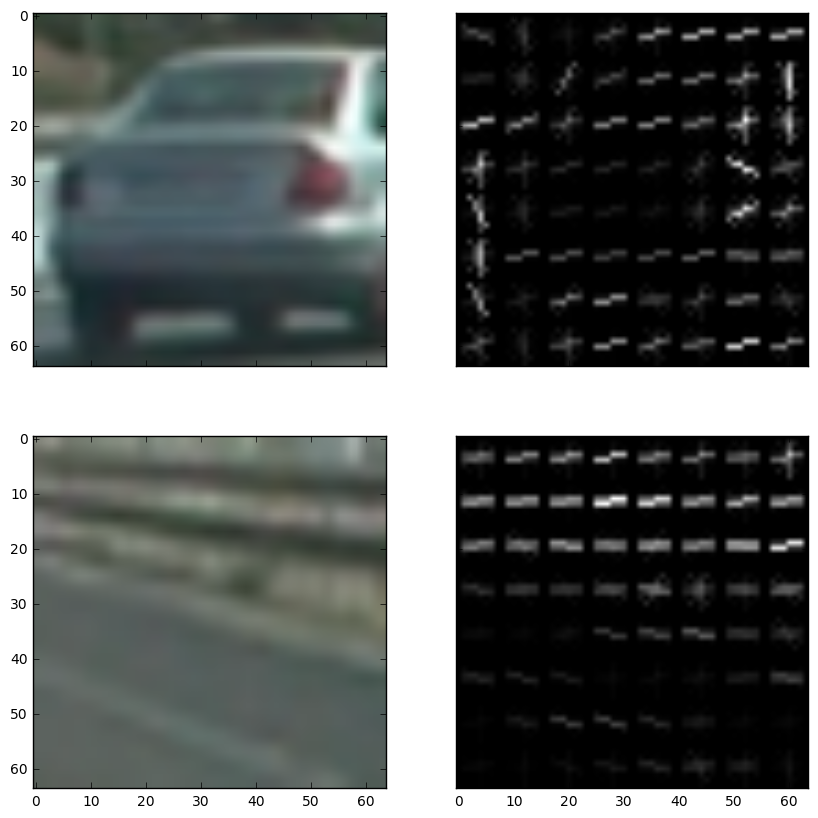

In [28]:
import Routines as ro
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import seaborn as sns
%matplotlib inline

car = mpimg.imread('vehicles/GTI_Left/image0009.png')
noncar = mpimg.imread('non-vehicles/GTI/image100.png')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=[10, 10])
_, hog_car = ro.get_hog_features(car[:,:,1], 9, 8, 2, vis=True, feature_vec=True)
_, hog_noncar = ro.get_hog_features(noncar[:,:,1], 9, 8, 2, vis=True, feature_vec=True)

ax1.imshow(car)
ax2.imshow(hog_car, cmap='gray')
ax3.imshow(noncar)
ax4.imshow(hog_noncar, cmap='gray')

I have employed an exhaustive grid search to come up with the following:
* 'color_space'= 'YCrCb'
* 'orient'= 9
* 'pix_per_cell' =  8
* 'cell_per_block' = 2
* 'hog_channel'= "ALL"
* 'spatial_size' = (32, 32)
* 'spatial_feat' =  True
* 'hist_feat' =  False
* 'hog_feat' = True

where the three boolean values indicate whether to include the particular feature. The rest of the feature names are self explanatory.

The grid search is performed in the function "param_search" under "detect.py". The goal of the search is to train a linear SVM classifier with all combination of parameters defined in the dictionary "param_grid" and pick the combination that maximizes the accuracy on the test dataset. (details later)

## 2. Classifier

## 3. Sliding Window Search

## 4. Video Implementation

The final annotated video is "project_video_annotated.mp4".

## 5. Discussions